## Setup
### Dataset for Evaluating Racial Biases in Facial Recognition, Proof of Concept

In [1]:
# Lint as: python3
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module
# ==============================================================================
"""Simple functions for embedding data in a notebook file."""

import base64
import mimetypes
import os
import pathlib
import textwrap

import IPython.display

class embed:
    def embed_data(mime: str, data: bytes) -> IPython.display.HTML:
      """Embeds data as an html tag with a data-url."""
      b64 = base64.b64encode(data).decode()
      if mime.startswith('image'):
        tag = f'<img src="data:{mime};base64,{b64}"/>'
      elif mime.startswith('video'):
        tag = textwrap.dedent(f"""
            <video width="640" height="480" controls>
              <source src="data:{mime};base64,{b64}" type="video/mp4">
              Your browser does not support the video tag.
            </video>
            """)
      else:
        raise ValueError('Images and Video only.')
      return IPython.display.HTML(tag)


    def embed_file(path: os.PathLike) -> IPython.display.HTML:
      """Embeds a file in the notebook as an html tag with a data-url."""
      path = pathlib.Path(path)
      mime, unused_encoding = mimetypes.guess_type(str(path))
      data = path.read_bytes()

      return embed.embed_data(mime, data)
#embed = embed()

In [2]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
#from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform
import random

In [3]:


# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

In [4]:
latent_dim = 512

## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

In [5]:
progan = hub.load('./').signatures['default']

In [6]:
def interpolate_between_vectors(v1, v2):
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images


In [7]:
def long_animation(seeds):
    last = None
    this = None
    interpolated_images = []
    for seed in seeds:
        last = this
        tf.random.set_seed(seed)
        this = tf.random.normal([latent_dim])
        
        try:
            interpolated_images.append(interpolate_between_vectors(this,last))
        except ValueError:
            pass

    return interpolated_images
 

### Define Dataset

In [8]:
#African female
af_seeds = []
af_seeds.append(98575)
af_seeds.append(12499)
af_seeds.append(72636)
af_seeds.append(88947)




#African male
am_seeds = []
am_seeds.append(20839)
am_seeds.append(24779)
am_seeds.append(15456)
am_seeds.append(25960)
am_seeds.append(29390)
am_seeds.append(44998)


#Caucasian female
cf_seeds = []
cf_seeds.append(29025)
cf_seeds.append(14624)
cf_seeds.append(38915)
cf_seeds.append(38918)


#Caucasian male
cm_seeds = []
cm_seeds.append(32832)
cm_seeds.append(38935)
cm_seeds.append(38933)
cm_seeds.append(38921)
cm_seeds.append(38930)

In [ ]:
tf.random.set_seed(am_seeds[0])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(am_seeds[1])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)


In [ ]:
tf.random.set_seed(am_seeds[3])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(am_seeds[4])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)


In [ ]:
tf.random.set_seed(af_seeds[0])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(af_seeds[1])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)

In [ ]:
tf.random.set_seed(af_seeds[2])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(af_seeds[3])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)

In [ ]:
tf.random.set_seed(cf_seeds[0])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(cf_seeds[1])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)

In [ ]:
tf.random.set_seed(cf_seeds[2])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(cf_seeds[3])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)


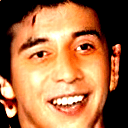

In [9]:
tf.random.set_seed(cm_seeds[0])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(cm_seeds[1])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)

In [ ]:
tf.random.set_seed(cm_seeds[2])
v1 = tf.random.normal([latent_dim])
tf.random.set_seed(cm_seeds[3])
v2 = tf.random.normal([latent_dim])

interpolated_images = interpolate_between_vectors(v1,v2)
animate(interpolated_images)

In [ ]:
seed = 59842
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
#animate(face_list_male)

In [ ]:
seed = 20839
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 24779
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 25656
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 15456
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 98575
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 12499
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 72636
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 25960
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 86199
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 29390
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 44998
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 88947
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 68600
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 29025

print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 14624
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 14638

print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

Compare the result to the target:

In [ ]:
seed = 38915
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38918
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38917
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38921
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38928
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38930
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38932
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38933
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38935
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 32832
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
seed = 38922
print(seed)
tf.random.set_seed(seed)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])